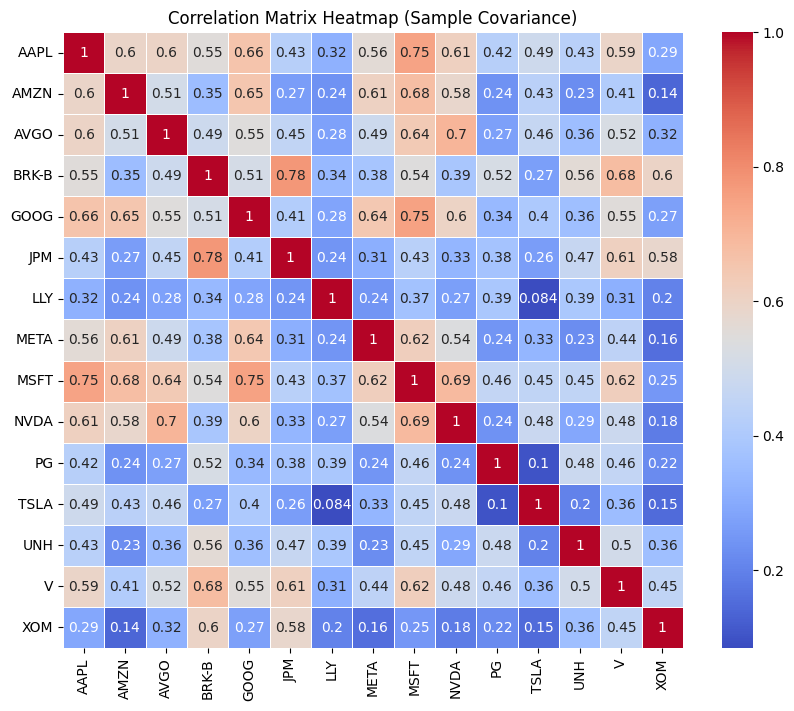

<Figure size 640x480 with 0 Axes>

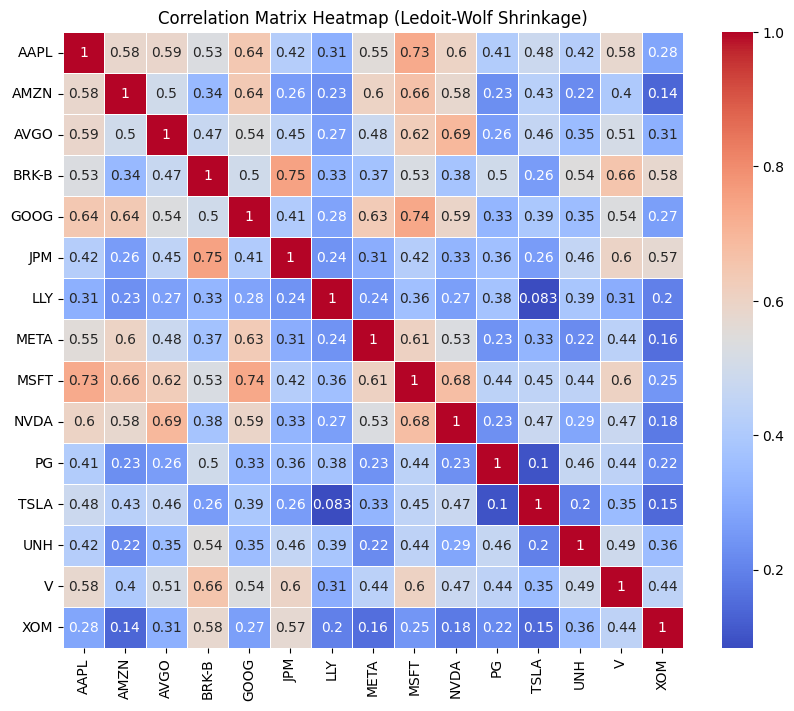

<Figure size 640x480 with 0 Axes>

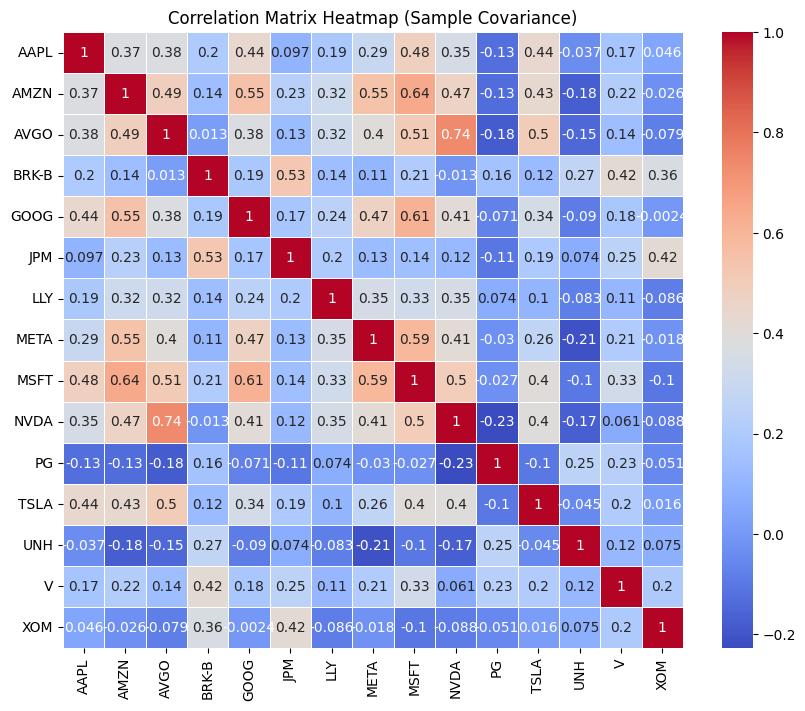

<Figure size 640x480 with 0 Axes>

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier

# Load prices
prices = pd.read_csv('adjust_close.csv')

# Set the 'date' column as the index
prices.set_index('date', inplace=True)

# Calculate daily percentage changes
returns = prices.pct_change(fill_method=None)
returns.dropna(inplace=True)

# Calculate covariance matrices using different methods
cov_matrix = returns.cov() * 252 
cov_pfopt = risk_models.sample_cov(prices, frequency=252)
cov_ledoit = risk_models.CovarianceShrinkage(prices, frequency=252).ledoit_wolf()
cov_exp = risk_models.exp_cov(prices, frequency=252)

# Convert covariance matrices to correlation matrices
def calculate_correlation(cov_matrix):
    variances = np.diag(cov_matrix) 
    std_dev = np.sqrt(variances)

    sd_df = pd.Series(std_dev, index=cov_matrix.index)

    # Divide by sd. to get correlation
    corr_matrix = cov_matrix.divide(sd_df, axis=0)  
    corr_matrix = corr_matrix.divide(sd_df, axis=1)

    return corr_matrix

corr_cov_pfopt = calculate_correlation(cov_pfopt)
corr_cov_ledoit = calculate_correlation(cov_ledoit)
corr_cov_exp = calculate_correlation(cov_exp)

# Plotting the correlation matrices as heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_pfopt, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Sample Covariance)')
plt.show()
plt.savefig('correlation_heatmap.png')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_ledoit, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Ledoit-Wolf Shrinkage)')
plt.show()
plt.savefig('correlation_heatmap_ledoit.png')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_exp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Sample Covariance)')
plt.show()
plt.savefig('correlation_heatmap_exp.png')



In [52]:
capm_returns = expected_returns.capm_return(prices)
print(capm_returns)

max_weight = (1 / len(prices.columns)) * 2
print(max_weight)

# Standard MVO, optimised for Sharpe Ratio
ef = EfficientFrontier(capm_returns, cov_matrix, weight_bounds=(0.01, max_weight))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


# MVO, optimised for minimum volatility
efmin = EfficientFrontier(capm_returns, cov_matrix, weight_bounds=(0.01, max_weight))
efmin.min_volatility()
weights = efmin.clean_weights()
print(weights)
efmin.portfolio_performance(verbose=True);



AAPL     0.386893
AMZN     0.375840
AVGO     0.452663
BRK-B    0.242140
GOOG     0.376180
JPM      0.311650
LLY      0.226188
META     0.458581
MSFT     0.386647
NVDA     0.606502
PG       0.167938
TSLA     0.594834
UNH      0.257139
V        0.317767
XOM      0.250504
Name: mkt, dtype: float64
0.13333333333333333
OrderedDict({'AAPL': 0.06667, 'AMZN': 0.06667, 'AVGO': 0.06667, 'BRK-B': 0.06667, 'GOOG': 0.06667, 'JPM': 0.06667, 'LLY': 0.06667, 'META': 0.06667, 'MSFT': 0.06667, 'NVDA': 0.06667, 'PG': 0.06667, 'TSLA': 0.06667, 'UNH': 0.06667, 'V': 0.06667, 'XOM': 0.06667})
Expected annual return: 36.1%
Annual volatility: 24.0%
Sharpe Ratio: 1.42
OrderedDict({'AAPL': 0.01, 'AMZN': 0.12665, 'AVGO': 0.01, 'BRK-B': 0.13333, 'GOOG': 0.02862, 'JPM': 0.01, 'LLY': 0.13333, 'META': 0.01, 'MSFT': 0.01, 'NVDA': 0.01, 'PG': 0.13333, 'TSLA': 0.01, 'UNH': 0.13333, 'V': 0.10807, 'XOM': 0.13333})
Expected annual return: 27.7%
Annual volatility: 19.8%
Sharpe Ratio: 1.30
